In [233]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io # 미니맵 처리
from sklearn.preprocessing import MinMaxScaler

In [37]:
# riot api
# RGAPI-7878fe8c-f7f2-4e2e-985f-8103910d5e13

# RATE LIMITS
# 20 requests every 1 seconds(s)
# 100 requests every 2 minutes(s)
# Note that rate limits are enforced per routing value (e.g., na1, euw1, americas).

# kr.api.riotgames.com

- 정글 시각에서 보는 분석
- 정글 유저 구분하기
- 정글 동선 찍어보기
- (1분 단위의)정글 동선을 예측 할 수 있을까?
- 3렙 탑갱이 승리에 끼치는 영향
- (미드, 정글), (탑, 정글) 좋은 조합

- 각 라인별 잘하는 사람의 특징
- 역전을 하기 위해서 가장 중요한 요소
- 

# 티어별 유저 기본 데이터 가져오기

In [38]:
api_key  = "RGAPI-11e434d2-459b-46f7-b66e-1b1caf7c91e4"
kr_api   = "https://kr.api.riotgames.com"
asia_api = "https://asia.api.riotgames.com"

challenger  = f"{kr_api}/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}"
grandmaster = f"{kr_api}/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}"

# /lol/league/v4/challengerleagues/by-queue/{queue}

# r = requests.get(challenger)  # 챌린져 호출
r = requests.get(grandmaster) # 그마데이터 호출
league_df = pd.DataFrame(r.json())

In [39]:
league_df.head(3)

,tier,leagueId,queue,name,entries
0,GRANDMASTER,a37af09b-ecb8-3664-9453-cf2b0138dd6e,RANKED_SOLO_5x5,Master Yi's Snipers,{'summonerId': 'wAr9jR-Cf1De03DheOIB403m12luib...
1,GRANDMASTER,a37af09b-ecb8-3664-9453-cf2b0138dd6e,RANKED_SOLO_5x5,Master Yi's Snipers,{'summonerId': '5HtHQITKqrpzn6qKjck1V29SLQc3HS...
2,GRANDMASTER,a37af09b-ecb8-3664-9453-cf2b0138dd6e,RANKED_SOLO_5x5,Master Yi's Snipers,{'summonerId': 'WpijOQIPxKJWUQys8KPIT9ZfFkUxRQ...


# 소환사 데이터 가져오기

In [41]:
summoner_id = "JXue7UC14-I2rh7H8TYAUfSxwpo1kw4Ii8dJA4LlVpEajJo"
summoner_name = "코로나공유"

player1  = f"{kr_api}/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
response = requests.get(player1)
data     = response.json()

In [42]:
data

{'id': 'JXue7UC14-I2rh7H8TYAUfSxwpo1kw4Ii8dJA4LlVpEajJo',
 'accountId': '5eiUjQC-_2v5pVRd2-4acVLPM0qWl3wYPniCbbpVDcHO-BM',
 'puuid': 'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ',
 'name': '코로나공유',
 'profileIconId': 29,
 'revisionDate': 1632582638000,
 'summonerLevel': 173}

In [43]:
summoner_puuid = data["puuid"]

In [44]:
match_list_api = f"{asia_api}/lol/match/v5/matches/by-puuid/{summoner_puuid}/ids?api_key={api_key}"
response       = requests.get(match_list_api)
match_list     = response.json()

# 기본 0부터 20개
match_list

['KR_5476691788',
 'KR_5476489810',
 'KR_5476449701',
 'KR_5476475155',
 'KR_5474254376',
 'KR_5474322054',
 'KR_5474340497',
 'KR_5474261454',
 'KR_5474194925',
 'KR_5474173379',
 'KR_5473749448',
 'KR_5473639354',
 'KR_5471556997',
 'KR_5469853340',
 'KR_5466288745',
 'KR_5466065552',
 'KR_5464868768',
 'KR_5464567334',
 'KR_5464479467',
 'KR_5464446203']

# match 데이터 가져오기
https://developer.riotgames.com/apis#match-v5/GET_getMatch

In [155]:
match_data_api   = f"{asia_api}/lol/match/v5/matches/{match_list[0]}?api_key={api_key}"
response         = requests.get(match_data_api)
match_basic_data = response.json()

In [156]:
match_basic_data.keys()

dict_keys(['metadata', 'info'])

In [47]:
# matchId와 10명의 플레이어들의 puuid
# match_data["metadata"]

## 시간 변환

In [167]:
# 소환사의 협곡 map_id == 11

# gameDuration 분으로 변환
print(1425655 / 1000 / 60)

# gameCreation 변환
from datetime import datetime
ts = int("1632606364")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

23.760916666666667
2021-09-25 21:46:04


In [158]:
match_basic_data["info"].keys()

dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])

In [200]:
# match_basic_data["info"]["participants"][1]["puuid"]
print(match_basic_data["info"]["participants"][1]["lane"])
match_basic_data["info"]["participants"][1]

JUNGLE


{'assists': 13,
 'baronKills': 1,
 'bountyLevel': 2,
 'champExperience': 12794,
 'champLevel': 14,
 'championId': 163,
 'championName': 'Taliyah',
 'championTransform': 0,
 'consumablesPurchased': 7,
 'damageDealtToBuildings': 2616,
 'damageDealtToObjectives': 16825,
 'damageDealtToTurrets': 2616,
 'damageSelfMitigated': 5816,
 'deaths': 6,
 'detectorWardsPlaced': 6,
 'doubleKills': 0,
 'dragonKills': 0,
 'firstBloodAssist': False,
 'firstBloodKill': False,
 'firstTowerAssist': False,
 'firstTowerKill': False,
 'gameEndedInEarlySurrender': False,
 'gameEndedInSurrender': False,
 'goldEarned': 9500,
 'goldSpent': 8450,
 'individualPosition': 'JUNGLE',
 'inhibitorKills': 0,
 'inhibitorTakedowns': 1,
 'inhibitorsLost': 0,
 'item0': 2421,
 'item1': 0,
 'item2': 1082,
 'item3': 6655,
 'item4': 3020,
 'item5': 3165,
 'item6': 3364,
 'itemsPurchased': 21,
 'killingSprees': 1,
 'kills': 4,
 'lane': 'JUNGLE',
 'largestCriticalStrike': 0,
 'largestKillingSpree': 2,
 'largestMultiKill': 1,
 'long

In [162]:
print(match_basic_data.keys())
print(match_basic_data["info"]["platformId"])
print(match_basic_data["info"]["queueId"])
print(match_basic_data["info"]["tournamentCode"])
# print(match_data["info"]["teams"])

dict_keys(['metadata', 'info'])
KR
420



In [51]:
# 분석해야 될 부분
# match_data["info"]["participants"]
# match_data["info"]["teams"]

In [52]:
# match_data["info"]["participants"][0]

# 타임라인 match 데이터 가져오기

In [53]:
timeline_match_api = f"{asia_api}/lol/match/v5/matches/{match_list[0]}/timeline?api_key={api_key}"

response   = requests.get(timeline_match_api)
time_match = response.json()
# time_match

In [54]:
time_match.keys()

dict_keys(['metadata', 'info'])

In [55]:
time_match["metadata"]

{'dataVersion': '2',
 'matchId': 'KR_5476691788',
 'participants': ['MztfXwjzTvrKkz1j0EvXpNCkULHOSLwv1DFBLmD_pGTKVRa1uvMQsrf2NMFssVxlz2ELaug0AFG03w',
  'wpEvO4swHjW_7-x0rdvib5k34bibIM6ITmQVk30psWbTAxev-Y9qxv2fKXi8rFxsRfna9-O3SPcMEQ',
  '6N8AZlBp7zpxlgtZMbZw12XTdynjCQvJY7CloVqXRyZAHyoVLq0hjXL1IkNJK0w9R3kDFK2XT5bgyw',
  'gTUIm-6pFIv6CQNiCAyps_dAIwcNgg7LUnzY-cXbagiHqfWVfIexl4l2S2l-60YqCgiSnKWii65BEA',
  'fphs3Jcef_rsNjGfW3E5vu4tBVYocZFaZ4oSMfvueOWGc4l37eqQ9k_jtweEJ950zBT92-mstTizSg',
  'YdvqFr3oRWLlSTXmnqV1tlRT46l7jkwcGaHaF7gdrLgh2T64RVYThZVP5ZEOIHQKu1-00ldhYOqmjg',
  'mpvRqYRVSZ3nfgsRhs8hA9XmPWKXtYVRAyvrK9eKx8yOG7OiddkN57yz85sS5ljRvFuygG_dqLmVqg',
  'ODlx2EE6YEy6t_FtX174b21XdG3TqxlnL1kS2GfTmyclTnCEawRtFUVaYh0KOj8N7F7qDvIRymSpZQ',
  'nzHWte_OsMS6wf0e_LNP5-uIzluyRfEFaOd1AfoeEycqXW7ynQ5b-4gtHvZKnf8iLY5rxqtgujgU1g',
  'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ']}

In [56]:
# frames 분석
time_match["info"].keys()

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])

In [187]:
time_match["info"]["participants"]

[{'participantId': 1,
  'puuid': 'MztfXwjzTvrKkz1j0EvXpNCkULHOSLwv1DFBLmD_pGTKVRa1uvMQsrf2NMFssVxlz2ELaug0AFG03w'},
 {'participantId': 2,
  'puuid': 'wpEvO4swHjW_7-x0rdvib5k34bibIM6ITmQVk30psWbTAxev-Y9qxv2fKXi8rFxsRfna9-O3SPcMEQ'},
 {'participantId': 3,
  'puuid': '6N8AZlBp7zpxlgtZMbZw12XTdynjCQvJY7CloVqXRyZAHyoVLq0hjXL1IkNJK0w9R3kDFK2XT5bgyw'},
 {'participantId': 4,
  'puuid': 'gTUIm-6pFIv6CQNiCAyps_dAIwcNgg7LUnzY-cXbagiHqfWVfIexl4l2S2l-60YqCgiSnKWii65BEA'},
 {'participantId': 5,
  'puuid': 'fphs3Jcef_rsNjGfW3E5vu4tBVYocZFaZ4oSMfvueOWGc4l37eqQ9k_jtweEJ950zBT92-mstTizSg'},
 {'participantId': 6,
  'puuid': 'YdvqFr3oRWLlSTXmnqV1tlRT46l7jkwcGaHaF7gdrLgh2T64RVYThZVP5ZEOIHQKu1-00ldhYOqmjg'},
 {'participantId': 7,
  'puuid': 'mpvRqYRVSZ3nfgsRhs8hA9XmPWKXtYVRAyvrK9eKx8yOG7OiddkN57yz85sS5ljRvFuygG_dqLmVqg'},
 {'participantId': 8,
  'puuid': 'ODlx2EE6YEy6t_FtX174b21XdG3TqxlnL1kS2GfTmyclTnCEawRtFUVaYh0KOj8N7F7qDvIRymSpZQ'},
 {'participantId': 9,
  'puuid': 'nzHWte_OsMS6wf0e_LNP5-uIzluyRfEFaOd1Af

In [57]:
match_data = time_match["info"]["frames"]
# match_data.keys()

In [58]:
"""
events: 게임 내에서 발생한 사건 데이터
participantFrames: 각 플레이어 인게임 정보
timestamp: 기록된 시간(1분마다 기록이 된다.)

match_data는 1분 단위로 기록됩니다.
"""
print(len(match_data))
match_data[0].keys()

25


dict_keys(['events', 'participantFrames', 'timestamp'])

In [109]:
# match_data[0]["participantFrames"]
match_data[24]["timestamp"]

1425658

In [229]:
# match_data[6]["participantFrames"]["1"]

In [143]:
time_match["info"].keys()

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])

In [60]:
print(match_data[2]["timestamp"])
# match_data[2]["participantFrames"]["1"]["position"]

for order_num in match_data[2]["participantFrames"]:
    print(match_data[2]["participantFrames"][order_num]["position"])

120019
{'x': 1068, 'y': 10892}
{'x': 3317, 'y': 7406}
{'x': 6096, 'y': 8495}
{'x': 11573, 'y': 1749}
{'x': 4500, 'y': 9061}
{'x': 1188, 'y': 11598}
{'x': 3424, 'y': 8705}
{'x': 6892, 'y': 8099}
{'x': 12880, 'y': 2827}
{'x': 12839, 'y': 1836}


In [223]:
# match_data[6]["events"]
# match_data[2]["events"]

In [62]:
map_url = "https://post-phinf.pstatic.net/MjAxNjEyMTFfMTQ2/MDAxNDgxNDM5NTE4MzE1.TlQRfGduXTSoPr0yHcW4ArdAhPgYfCrI7nFi7IraVoQg.KDQlAEv5r31S0lDXYSsnKJXx6Il0gR1L8xOc_oCKKokg.JPEG/image_6963812281481439508693.jpg?type=w1200"
print(map_url)

https://post-phinf.pstatic.net/MjAxNjEyMTFfMTQ2/MDAxNDgxNDM5NTE4MzE1.TlQRfGduXTSoPr0yHcW4ArdAhPgYfCrI7nFi7IraVoQg.KDQlAEv5r31S0lDXYSsnKJXx6Il0gR1L8xOc_oCKKokg.JPEG/image_6963812281481439508693.jpg?type=w1200


In [224]:
# events
# participantFrames
# timestamp
# match_data[2]["events"]

In [77]:
for event in match_data[3]["events"]:
    print(event["type"], event["timestamp"])

LEVEL_UP 129204
SKILL_LEVEL_UP 129898
ITEM_DESTROYED 132574
LEVEL_UP 138390
LEVEL_UP 139050
SKILL_LEVEL_UP 139182
LEVEL_UP 141396
LEVEL_UP 141396
LEVEL_UP 141495
SKILL_LEVEL_UP 141892
SKILL_LEVEL_UP 142157
SKILL_LEVEL_UP 142157
SKILL_LEVEL_UP 144402
ITEM_DESTROYED 146286
CHAMPION_KILL 147607
CHAMPION_SPECIAL_KILL 147607
ITEM_SOLD 149457
ITEM_SOLD 149655
ITEM_SOLD 149787
ITEM_PURCHASED 150612
ITEM_PURCHASED 150745
ITEM_UNDO 153486
ITEM_UNDO 153651
ITEM_UNDO 153783
LEVEL_UP 154344
ITEM_UNDO 154840
ITEM_UNDO 154972
LEVEL_UP 158116
SKILL_LEVEL_UP 159636
SKILL_LEVEL_UP 160428
LEVEL_UP 168692
LEVEL_UP 169353
SKILL_LEVEL_UP 170013
CHAMPION_KILL 171103
SKILL_LEVEL_UP 171400
CHAMPION_KILL 178932
CHAMPION_SPECIAL_KILL 178932
TURRET_PLATE_DESTROYED 179460
LEVEL_UP 179460
CHAMPION_KILL 179923


In [227]:
match_data[3]["events"][36]

{'killType': 'KILL_MULTI',
 'killerId': 7,
 'multiKillLength': 2,
 'position': {'x': 1171, 'y': 10172},
 'timestamp': 178932,
 'type': 'CHAMPION_SPECIAL_KILL'}

In [131]:
# 챔피언 킬 날때 position 나옴
# match_data[3]["events"][33]

In [199]:
match_data[2]["participantFrames"]["1"]

{'championStats': {'abilityHaste': 0,
  'abilityPower': 0,
  'armor': 29,
  'armorPen': 0,
  'armorPenPercent': 0,
  'attackDamage': 84,
  'attackSpeed': 100,
  'bonusArmorPenPercent': 0,
  'bonusMagicPenPercent': 0,
  'ccReduction': 5,
  'cooldownReduction': 0,
  'health': 141,
  'healthMax': 580,
  'healthRegen': 180,
  'lifesteal': 0,
  'magicPen': 0,
  'magicPenPercent': 0,
  'magicResist': 37,
  'movementSpeed': 345,
  'omnivamp': 0,
  'physicalVamp': 0,
  'power': 200,
  'powerMax': 200,
  'powerRegen': 100,
  'spellVamp': 0},
 'currentGold': 21,
 'damageStats': {'magicDamageDone': 154,
  'magicDamageDoneToChampions': 154,
  'magicDamageTaken': 0,
  'physicalDamageDone': 189,
  'physicalDamageDoneToChampions': 189,
  'physicalDamageTaken': 507,
  'totalDamageDone': 343,
  'totalDamageDoneToChampions': 343,
  'totalDamageTaken': 550,
  'trueDamageDone': 0,
  'trueDamageDoneToChampions': 0,
  'trueDamageTaken': 42},
 'goldPerSecond': 0,
 'jungleMinionsKilled': 0,
 'level': 1,
 'min

In [230]:
image = io.imread(map_url)

In [235]:
x, y = 1068, 10892

In [245]:
image[-1]

array([[27, 60, 41],
       [29, 62, 43],
       [27, 58, 40],
       ...,
       [56, 75, 81],
       [66, 85, 91],
       [60, 79, 85]], dtype=uint8)

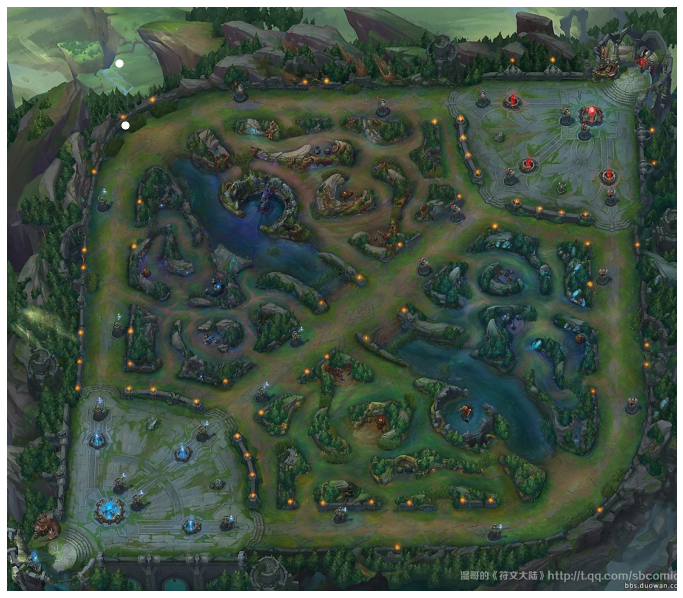

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter([200, 210], [100, 210], c='white', s=50)
ax.axis('off')
ax.imshow(image)
plt.show()